In [77]:
using Images, Plots, FFTW#, FileIO
using JuMP, GLPK, Cbc, Optim
using SparseArrays, LinearAlgebra
using ForwardDiff

LoadError: ArgumentError: Package DFT not found in current path:
- Run `import Pkg; Pkg.add("DFT")` to install the DFT package.


In [ ]:
optimize()

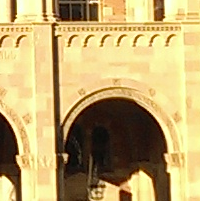

In [97]:
building = load("building.tif")[100:300, begin:200]

In [98]:
size(building)

(201, 200)

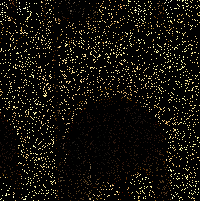

In [100]:
U = Float16
sampling_density = 0.1
sampling_matrix = rand(U, size(building)) .< sampling_density
sampled_image = sampling_matrix .* building
# Vector form is building[sampling_matrix]

In [110]:
function optimizer(sampled_image, sampling_matrix; lambda = 5.)
    U = Float16
    image_as_array = convert(Array{U}, channelview(sampled_image))
    nsamples = sum(sampling_matrix)
    nc, nx, ny = size(image_as_array)
    
    IDCTx = idct(I(nx), 1)
    IDCTy = idct(I(ny), 2)
    
    model = Model(Cbc.Optimizer)    
    @variable(model, fft_pred[1:nc, 1:nx, 1:ny]) 
    @variable(model, t[1:nc, 1:nx, 1:ny])
    
    @constraint(model, tAbs1[i in 1:nc, j in 1:nx, k in 1:ny],
                - t[i, j, k] ≤ fft_pred[i, j, k])
    @constraint(model, tAbs2[i in 1:nc, j in 1:nx, k in 1:ny],
                fft_pred[i, j, k] ≤ t[i, j, k])
        
    for j in 1:nx, k in 1:ny
        if sampling_matrix[j, k]
            for ch in 1:nc
                @constraint(model, (IDCTx * fft_pred[ch, :, :] * IDCTy)[j, k]
                                    == image_as_array[ch, j, k])
            end
        end
    end
    
    @objective(model, Min, sum(t))
        
    optimize!(model)
    print(solution_summary(model))
    return value.(fft_pred), colorview(RGB, idct(value.(fft_pred), (2, 3)))
end

optimizer (generic function with 1 method)

In [ ]:
res, img = optimizer(sampled_image, sampling_matrix)

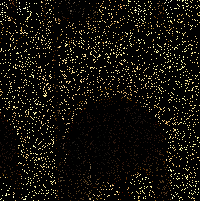

In [108]:
sampled_image

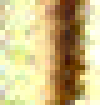

In [109]:
img

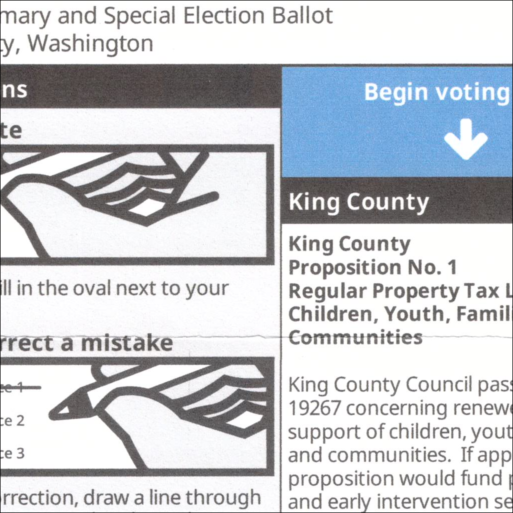

In [2]:
ballot = load("ballot.tif")

In [18]:
function fftcompress(img; ratio=100::Int)
    n_pixels = *(size(ballot)...)
    k = n_pixels ÷ ratio
    compressed_image = fill(spzeros(ComplexF32, size(ballot)...), 3)
    
    for c in 1:3
        curr_channel = channelview(img)[c, :, :]
        curr_channel_fft = fft(curr_channel)
        biggest = partialsortperm(abs.(curr_channel_fft)[:], 1:k)
        compressed_channel = spzeros(size(curr_channel_fft)...)
        compressed_image[c][biggest] = curr_channel_fft[biggest]
    end
    return compressed_image
end

function fftextract(compressed_image)
    res = Matrix{Float32}[]
    
    for c in 1:3
        push!(res, real.(ifft(Array(compressed_image[c]))))
    end

    return colorview(RGB, fftextract(res)...)
end

fftextract (generic function with 1 method)

In [52]:
function fftcompress(img; ratio=100::Int)
    n_pixels = *(size(ballot)...)
    k = n_pixels ÷ ratio
    compressed_image = fft(channelview(img), [2, 3, 1])
    
    smallest = partialsortperm(abs.(compressed_image)[:], 1:(n_pixels - k))
    compressed_image[smallest] .= 0
    
    return compressed_image
end

function fftextract(compressed_image)
    res = Matrix{Float32}[]
    
    for c in 1:3
        push!(res, real.(ifft(Array(compressed_image[c]))))
    end

    return colorview(RGB, fftextract(res)...)
end

fftextract (generic function with 1 method)

In [ ]:
colorview(RGB, log1p.(abs.(fftcompress(ballot)))...)

In [31]:
A[3, :, :][6] = 1

1

In [45]:
A[3, 1 + 6 ÷ 4,1 + 6 % 5]

0.7803129499486781

In [49]:
A[3, 1:20] = 20*rand(20)

LoadError: BoundsError: attempt to access 3×4×5 Array{Float64, 3} at index [3, 1:20]

In [48]:
A

3×4×5 Array{Float64, 3}:
[:, :, 1] =
 0.0083888   0.675627   0.192844   0.904304
 0.134805    0.630613   0.199485   0.960607
 5.66499    12.0153    11.0322    14.1609

[:, :, 2] =
 0.86504    0.837088  0.169079  0.756001
 0.641307   0.264713  0.698031  0.0297275
 6.39761   13.1081    1.99914   7.90935

[:, :, 3] =
  0.972775  0.493025   0.0436617  0.327555
  0.854991  0.463111   0.361743   0.665394
 18.6627    3.12798   18.236      1.37135

[:, :, 4] =
  0.60619    0.907227   0.842186   0.939351
  0.0885037  0.175786   0.244299   0.227197
 17.8788     6.26752   11.7211    13.8822

[:, :, 5] =
 0.569271   0.161804  0.219508  0.645425
 0.0792641  0.634001  0.348098  0.963307
 5.00076    1.9662    3.10573   4.88919

In [16]:
fftcompress(ballot; ratio=10)# |> fftextract

3-element Vector{SparseMatrixCSC{ComplexF32, Int64}}:
 
⠀⠀⠀⠀⡀⢀⠀⡂⢡⣱⣺⣿⣾⢇⣾⣮⣾⣿⣿⣾⣷⣿⣶⣷⣾⣿⣮⣗⣠⣠⣴⢐⢠⢄⠄⠈⠀⠀⠀⠀
⠀⠀⠘⠀⠄⠈⣳⢠⢶⣷⣷⣿⣺⣷⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣟⡭⡏⡁⣀⢂⡌⠀⠀⠀
⠂⡐⠈⠡⠈⢡⠉⢬⠽⡿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣟⣿⣻⢟⢧⢧⢗⣆⢘⠐⢀⠀
⢀⣄⡔⢬⠼⢰⣵⢵⣿⣟⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣟⣿⣿⣿⣬⣗⡲⡆⣏⡀⢀⠄
⢠⣥⣠⢍⣾⣼⣻⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣟⣿⢞⣞⡗⣜⡄
⢲⣿⣿⣷⣷⣷⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣛⣻⣽⢾⡷
⣺⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣻⣿⣇
⣾⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡯
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣸⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⡿
⢹⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡯
⢺⣗⣟⣿⣯⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⢿⣽⢿⣿⣿⡧
⠘⡹⢼⠽⡿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡟⡿⣘⠙⢛⠇
⠐⠁⠐⢹⠰⠮⠽⣛⣿⣿⣻⣽⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⢷⣟⡇⡖⡓⠜⠙⠁
⠀⠁⠄⡁⠹⢼⢳⢣⣳⣯⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣽⢖⡓⣀⢃⡀⠂⡀⠌⠠
⠀⠀⠀⡨⠡⠑⢈⣸⣚⣽⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⢿⡯⣾⢷⢿⠿⠃⢮⡀⠐⠈⡄⠀⠀
⠀⠀⠀⠀⡀⠐⠑⠃⠅⠟⠋⠋⡿⣛⣿⣿⣿⠿⣿⣿⣿⣿⡿⣿⡿⣿⠵⣿⣿⡯⢏⢃⠨⠀⠈⠈⠀⠀⠀⠀
 
⠀⠀⠀⠀⡀⢀⠀⡂⢡⣱⣺⣿⣾⢇⣾⣮⣾⣿⣿⣾⣷⣿⣶⣷⣾⣿⣮⣗⣠⣠⣴⢐⢠⢄⠄⠈⠀⠀⠀⠀
⠀⠀⠘⠀⠄⠈⣳⢠⢶⣷⣷⣿⣺⣷⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣟⡭⡏⡁⣀⢂⡌⠀⠀⠀
⠂⡐⠈⠡⠈⢡⠉⢬⠽⡿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣟⣿⣻⢟⢧⢧⢗⣆⢘⠐⢀⠀

64×64 SparseMatrixCSC{Float16, Int64} with 1027 stored entries:
⢀⡅⠀⢰⡀⡀⠌⢐⠈⠁⢂⡂⠀⡠⠀⠪⠓⠈⠀⢂⡂⡁⠌⡄⠀⢨⡈⠑⠪⡐⡰⡰
⢀⠀⡎⠎⢔⠂⡁⠜⠠⣦⠠⣣⡓⡄⢠⡐⠂⣦⢠⡉⡊⠄⠈⠂⡉⠨⣀⢀⣀⠐⠣⠀
⢐⡀⠆⠀⠰⣠⢒⡋⠈⢂⠠⣡⣞⣙⠀⠄⠉⡮⡐⣂⡼⣘⠀⠄⣂⡂⣇⠈⠃⡞⠐⠀
⠀⢒⠁⢀⠥⢁⠐⡅⡄⠺⠀⢁⠐⠁⠀⠋⡨⡌⠅⠚⣁⣐⠤⡦⣤⠊⠂⠐⣂⡀⢀⠈
⢱⠀⢈⠀⢐⡊⡀⠈⠁⢊⠈⡈⡜⡀⣀⠄⠠⠡⠜⠐⠖⢑⠮⠢⠐⠀⡙⢨⠂⢀⡅⡅
⢨⠄⠀⠀⠁⡅⠌⠇⠊⡘⢐⠐⠃⠰⢀⠔⡘⡀⠴⡘⡔⠼⣈⠢⠴⠁⠂⡅⠔⡔⢠⢈
⠱⢇⠘⠀⠁⠀⠊⠅⡘⠤⠭⡌⠢⠗⠅⢓⠒⡁⢌⡐⠆⡁⡂⡒⠂⠐⠀⢊⠱⠘⠀⠉
⠀⠙⠊⠂⢀⠢⡈⠁⣨⠉⠄⠄⠈⠉⠁⠡⠀⠄⡂⢢⠩⡀⡂⢑⠂⠹⠁⠄⢹⡨⡢⡀
⠠⢆⠃⠀⠑⠂⡄⠐⢐⠁⠂⠇⠅⢉⠇⢎⢀⠤⢸⠂⡑⢍⠈⡍⡁⠌⡕⡍⠰⠄⡔⠀
⠅⡀⠢⠂⣓⠀⠄⡃⣠⠀⡀⠉⠅⠂⠘⢠⠉⠠⢥⠟⢆⢌⢥⢤⠀⣁⠐⡄⠀⢐⢊⠂
⠅⠀⢂⠠⠡⠈⣓⠔⠀⠈⠵⣥⠄⡀⠁⠄⡈⠸⠐⠠⢃⠦⣄⡄⠠⠠⠄⠈⠬⣀⠈⠂
⠎⠏⡃⠣⢀⠙⠠⠀⡐⡂⠐⡈⡠⡂⡶⠊⢌⠄⡀⡄⣀⠥⠁⡉⠠⠌⢀⠸⠔⠐⢀⢀
⠘⢲⠬⣀⠀⢀⠀⢈⠒⠀⠂⠠⠌⠆⠀⠀⠁⡆⢠⢒⠄⢎⢱⠀⠀⡑⣊⠀⡒⠣⠠⠐
⡰⠀⠀⡋⢀⠈⢀⠀⠐⠁⠠⠍⡔⡒⠂⠐⢀⠋⠐⠕⡤⢥⠐⡀⣎⠣⢄⡀⠆⡀⠂⣹
⠀⡰⡲⠖⠉⠂⡓⣅⠊⢂⠀⠄⣀⠈⡣⠑⢘⠖⠄⠑⠙⢃⠀⠜⡃⢌⣬⠰⠰⢦⠉⣀
⠂⡅⠃⠀⠀⠨⠁⠀⠀⡀⣀⠀⠐⠸⠵⠂⡈⢚⠌⠊⡀⢶⠀⡌⠃⠠⠄⢀⡆⠀⠘⠅

In [111]:
res = fftcompress(ballot)

3-element Vector{SparseMatrixCSC{ComplexF32, Int64}}:
 
⠀⠀⠀⠀⡀⢀⠀⡂⢡⣱⣺⣿⣾⢇⣾⣮⣾⣿⣿⣾⣷⣿⣶⣷⣾⣿⣮⣗⣠⣠⣴⢐⢠⢄⠄⠈⠀⠀⠀⠀
⠀⠀⠘⠀⠄⠈⣳⢠⢶⣷⣷⣿⣺⣷⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣟⡭⡏⡁⣀⢂⡌⠀⠀⠀
⠂⡐⠈⠡⠈⢡⠉⢬⠽⡿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣟⣿⣻⢟⢧⢧⢗⣆⢘⠐⢀⠀
⢀⣄⡔⢬⠼⢰⣵⢵⣿⣟⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣟⣿⣿⣿⣬⣗⡲⡆⣏⡀⢀⠄
⢠⣥⣠⢍⣾⣼⣻⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣟⣿⢞⣞⡗⣜⡄
⢲⣿⣿⣷⣷⣷⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣛⣻⣽⢾⡷
⣺⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣻⣿⣇
⣾⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡯
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣸⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⡿
⢹⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡯
⢺⣗⣟⣿⣯⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⢿⣽⢿⣿⣿⡧
⠘⡹⢼⠽⡿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡟⡿⣘⠙⢛⠇
⠐⠁⠐⢹⠰⠮⠽⣛⣿⣿⣻⣽⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⢷⣟⡇⡖⡓⠜⠙⠁
⠀⠁⠄⡁⠹⢼⢳⢣⣳⣯⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣽⢖⡓⣀⢃⡀⠂⡀⠌⠠
⠀⠀⠀⡨⠡⠑⢈⣸⣚⣽⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⢿⡯⣾⢷⢿⠿⠃⢮⡀⠐⠈⡄⠀⠀
⠀⠀⠀⠀⡀⠐⠑⠃⠅⠟⠋⠋⡿⣛⣿⣿⣿⠿⣿⣿⣿⣿⡿⣿⡿⣿⠵⣿⣿⡯⢏⢃⠨⠀⠈⠈⠀⠀⠀⠀
 
⠀⠀⠀⠀⡀⢀⠀⡂⢡⣱⣺⣿⣾⢇⣾⣮⣾⣿⣿⣾⣷⣿⣶⣷⣾⣿⣮⣗⣠⣠⣴⢐⢠⢄⠄⠈⠀⠀⠀⠀
⠀⠀⠘⠀⠄⠈⣳⢠⢶⣷⣷⣿⣺⣷⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣟⡭⡏⡁⣀⢂⡌⠀⠀⠀
⠂⡐⠈⠡⠈⢡⠉⢬⠽⡿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣟⣿⣻⢟⢧⢧⢗⣆⢘⠐⢀⠀

In [ ]:
fftextract(res)

In [15]:
comp = fftcompress(ballot)
fftextract(comp)

LoadError: MethodError: no method matching plan_bfft(::SparseMatrixCSC{ComplexF16, Int64}, ::UnitRange{Int64})
[0mClosest candidates are:
[0m  plan_bfft([91m::StridedArray{T, N}[39m, ::Any; flags, timelimit) where {T<:Union{ComplexF32, ComplexF64}, N} at C:\Users\Max\.julia\packages\FFTW\kKdEk\src\fft.jl:685
[0m  plan_bfft([91m::AbstractArray{var"#s14", N} where {var"#s14"<:Real, N}[39m, ::Any; kws...) at C:\Users\Max\.julia\packages\AbstractFFTs\JebmH\src\definitions.jl:199
[0m  plan_bfft([91m::AbstractArray{var"#s5", N} where {var"#s5"<:(Complex{var"#s4"} where var"#s4"<:Union{Integer, Rational}), N}[39m, ::Any; kws...) at C:\Users\Max\.julia\packages\AbstractFFTs\JebmH\src\definitions.jl:201
[0m  ...

In [18]:
comp[2]

1024×1024 SparseMatrixCSC{ComplexF16, Int64} with 133588 stored entries:
⠀⠀⠀⠀⡀⢀⠀⡂⢡⣱⣺⣿⣾⢇⣾⣮⣾⣿⣿⣾⣷⣿⣶⣷⣾⣿⣮⣗⣠⣠⣴⢐⢠⢄⠄⠈⠀⠀⠀⠀
⠀⠀⠘⠀⠄⠈⣳⢠⢶⣷⣷⣿⣺⣷⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣟⡭⡏⡁⣀⢂⡌⠀⠀⠀
⠂⡐⠈⠡⠈⢡⠉⢬⠽⡿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣟⣿⣻⢟⢧⢧⢗⣆⢘⠐⢀⠀
⢀⣄⡔⢬⠼⢰⣵⢵⣿⣟⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣟⣿⣿⣿⣬⣗⡲⡆⣏⡀⢀⠄
⢠⣥⣠⢍⣾⣼⣻⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣟⣿⢞⣞⡗⣜⡄
⢲⣿⣿⣷⣷⣷⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣛⣻⣽⢾⡷
⣺⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣻⣿⣇
⣾⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡯
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣸⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⡿
⢹⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡯
⢺⣗⣟⣿⣯⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⢿⣽⢿⣿⣿⡧
⠘⡹⢼⠽⡿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡟⡿⣘⠙⢛⠇
⠐⠁⠐⢹⠰⠮⠽⣛⣿⣿⣻⣽⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⢷⣟⡇⡖⡓⠜⠙⠁
⠀⠁⠄⡁⠹⢼⢳⢣⣳⣯⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣽⢖⡓⣀⢃⡀⠂⡀⠌⠠
⠀⠀⠀⡨⠡⠑⢈⣸⣚⣽⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⢿⡯⣾⢷⢿⠿⠃⢮⡀⠐⠈⡄⠀⠀
⠀⠀⠀⠀⡀⠐⠑⠃⠅⠟⠋⠋⡿⣛⣿⣿⣿⠿⣿⣿⣿⣿⡿⣿⡿⣿⠵⣿⣿⡯⢏⢃⠨⠀⠈⠈⠀⠀⠀⠀

In [98]:
Matrix(sprand(Float64, 3, 3, .5))

3×3 Matrix{Float64}:
 0.157307  0.0       0.0
 0.0       0.938423  0.291256
 0.0       0.520385  0.729913

In [7]:
a = fft(channelview(ballot), [2, 3, 1])

# colorview(RGB, ifft(a, [2, 3, 1])...)

3×1024×1024 Array{ComplexF32, 3}:
[:, :, 1] =
 2.53371f6+0.0im       37573.1+1.55214f5im  …   37573.1-1.55214f5im
  -25176.0+18017.9im   12996.9+27144.4im       -17890.5-25303.9im
  -25176.0-18017.9im  -17890.5+25303.9im        12996.9-27144.4im

[:, :, 2] =
  19204.2+20042.1im  -11688.5+72220.6im  …  40587.8+22388.4im
 -11608.3-20320.6im  -20162.8+10569.8im     16814.7-14863.2im
  8626.59-20886.2im  -19854.7-11884.9im     21594.1+6799.35im

[:, :, 3] =
 16709.3+8969.45im  -14986.1-16575.0im  …  -26498.2+12497.2im
 3391.31-1973.43im  -1339.25-3770.61im      1706.49+3427.32im
 3109.62+1693.85im   2771.68-2964.52im     -1854.24+2799.73im

...

[:, :, 1022] =
  -1517.0+16759.2im  33661.7+3094.41im  …   3624.09-41272.3im
 -891.888+6181.9im   6237.84+1536.87im     -6117.54+1111.37im
  -5526.1+2778.17im  1670.83+5990.5im      -4076.28-4630.45im

[:, :, 1023] =
 16709.3-8969.45im  -26498.2-12497.2im  …  -14986.1+16575.0im
 3109.62-1693.85im  -1854.24-2799.73im      2771.68+2964.52im
 3391.31+

In [ ]:
colorview(RGB, ifft(a)...)

In [4]:
red_channel_fft = FFTW.r2r(red_channel, 1, 2)

1024×1024 Matrix{Float64}:
 1024.0    -651.897    0.0       -217.293  …  217.293    0.0       651.897
 1024.0    -651.897    0.0       -217.293     217.293    0.0       651.897
 1024.0    -651.897    0.0       -217.293     217.293    0.0       651.897
 1024.0    -651.897    0.0       -217.293     217.293    0.0       651.897
 1024.0    -651.897    0.0       -217.293     217.293    0.0       651.897
 1024.0    -651.897    0.0       -217.293  …  217.293    0.0       651.897
 1024.0    -651.897    0.0       -217.293     217.293    0.0       651.897
 1022.71   -651.212   -0.110063  -216.691     216.633    1.00826   651.926
 1022.33   -650.817   -0.336636  -216.915     216.319    0.847356  652.285
 1023.09   -651.269   -0.257153  -216.559     216.525    1.02344   651.787
 1018.6    -646.759   -3.51269   -214.06   …  210.494    5.82681   651.44
 1009.0    -641.066   -5.51235   -210.066     205.89    12.0133    652.183
  989.451  -631.191   -4.32613   -206.784     196.711   22.5126    657.07


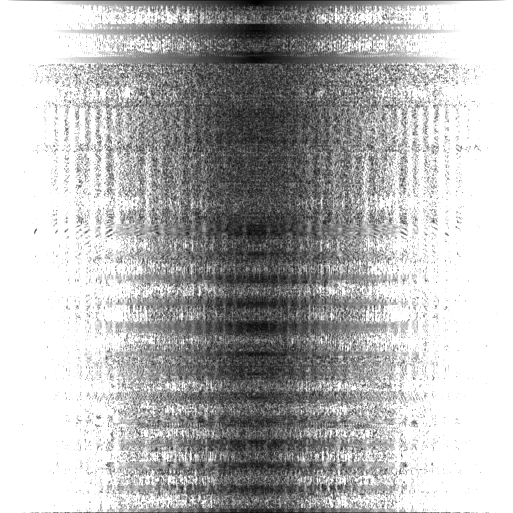

In [6]:
Gray.(log1p.(abs.(red_channel_fft)))

In [22]:
spzeros(size(red_channel_fft)...)
# red_channel_fft[partialsortperm(red_channel_fft[:], 1:20)]

1024×1024 SparseMatrixCSC{Float64, Int64} with 0 stored entries:
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀

In [ ]:
using FFTW, SparseArrays

fft(rand(Float64, 50, 50))
fft(rand(ComplexF64, 50, 50))
fft(rand(Float32, 50, 50))
fft(rand(ComplexF32, 50, 50))
fft(rand(Float16, 50, 50))
# fft(rand(ComplexF16, 50, 50))

fft(sprand(Float64, 50, 50, 0.2))
# fft(sprand(ComplexF64, 50, 50, 0.2))
fft(sprand(Float32, 50, 50, 0.2))
# fft(sprand(ComplexF32, 50, 50, 0.2))
fft(sprand(Float16, 50, 50, 0.2))
# fft(sprand(ComplexF16, 50, 50, 0.2))

ifft(rand(Float64, 50, 50))
ifft(rand(ComplexF64, 50, 50))
ifft(rand(Float32, 50, 50))
ifft(rand(ComplexF32, 50, 50))
ifft(rand(Float16, 50, 50))
# ifft(rand(ComplexF16, 50, 50))
    
ifft(sprand(Float64, 50, 50, 0.2))
# ifft(sprand(ComplexF64, 50, 50, 0.2))
ifft(sprand(Float32, 50, 50, 0.2))
# ifft(sprand(ComplexF32, 50, 50, 0.2))
ifft(sprand(Float16, 50, 50, 0.2))
# ifft(sprand(ComplexF16, 50, 50, 0.2))

In [11]:
FFTW.r2r(channelview(ballot), 2, 3, 1)

LoadError: MethodError: no method matching r2r(::Base.ReinterpretArray{N0f8, 3, RGB{N0f8}, TiffImages.DenseTaggedImage{RGB{N0f8}, 2, UInt32, Matrix{RGB{N0f8}}}, true}, ::Int64, ::Int64, ::Int64)
[0mClosest candidates are:
[0m  r2r(::AbstractArray{var"#s74", N} where {var"#s74"<:Real, N}, ::Any, ::Any) at C:\Users\Max\.julia\packages\FFTW\kKdEk\src\fft.jl:826
[0m  r2r([91m::AbstractArray{var"#s77", N} where {var"#s77"<:Union{Float32, Float64, ComplexF32, ComplexF64}, N}[39m, ::Any, ::Any) at C:\Users\Max\.julia\packages\FFTW\kKdEk\src\fft.jl:824
[0m  r2r(::AbstractArray{var"#s75", N} where {var"#s75"<:Real, N}, ::Any) at C:\Users\Max\.julia\packages\FFTW\kKdEk\src\fft.jl:826
[0m  ...

In [18]:
*(size(ballot)...) ÷ 3

349525